In [1]:
import warnings
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
train_ds = np.loadtxt('../assets/train_dataset0-4.txt', dtype=float)
test_ds = np.loadtxt('../assets/test_dataset5-9.txt', dtype=float)

In [3]:
def data_extract(train_data):
    data_list = list()
    label_list = list()
    for val in train_data:
        data_list.append(val[0:784])
        label_list.append(int(val[784]))
    data_list = np.array(data_list)
    label_list = np.array(label_list)
    return data_list, label_list

np.random.shuffle(train_ds)

x_train, y_train = data_extract(train_ds)
x_test, y_test = data_extract(test_ds)
# x_train = x_train / 255

In [4]:
y_train

array([4, 1, 3, ..., 0, 1, 1])

In [5]:
warnings.filterwarnings('ignore')
EPOCHS = 1000
hidden_neurons = 180

In [6]:
class NeuralNetwork():
    
    def __init__(self, input_nn: int, output_nn: int, hidden_nn: list, hidden_layers: int, learning_rate=0.01, alpha=0.5, epochs=EPOCHS, high=0.75, low=0.25):
        self.input_nn = input_nn
        self.output_nn = output_nn
        self.hidden_nn = hidden_nn
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.epochs = epochs
        self.high = high
        self.low = low
        self.b = 1
        self.y_hat = OrderedDict()
        self.w1 = np.random.randn(self.hidden_nn[0], self.input_nn) * np.sqrt(1 / (self.input_nn + self.hidden_nn[0]))
        if hidden_layers < 2:
            self.w2 = np.random.randn(self.output_nn, self.hidden_nn[0]) * np.sqrt(1 / (self.output_nn + self.hidden_nn[0]))
        else:
            self.w_dict = dict()
            for i in range(self.hidden_layers):
                temp = 'w' + str(i + 2)
                if self.hidden_layers - i == 1:
                    self.w_dict[temp] = np.random.rand(self.output_nn, self.hidden_nn[i]) * np.sqrt(1 / (self.output_nn + self.hidden_nn[i]))
                    break
                self.w_dict[temp] = np.random.rand(self.hidden_nn[i + 1], self.hidden_nn[i]) * np.sqrt(1 / (self.hidden_nn[i + 1] + self.hidden_nn[i]))
    
        
    def get_weight(self):
        if self.hidden_layers >= 2:
            return self.w1, self.w_dict
        return self.w1, self.w2
    
    
    def sigmoid(self, x): 
        return 1.0/(1.0 + np.exp(-x))


    def deri_sigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    
    def forward_prop(self, input_ds):
        self.s1 = np.dot(input_ds, self.w1.T) + self.b
        self.y_hat1 = self.sigmoid(self.s1)
        if self.hidden_layers < 2:
            self.s2 = np.dot(self.y_hat1, self.w2.T) + self.b # net input 
            self.y_hat2 = self.sigmoid(self.s2) # activation function for the output layer.
        else:
            self.s2 = np.dot(self.y_hat1, self.w_dict['w2'].T) + self.b # net input 
            self.y_hat['y_hat2'] = self.sigmoid(self.s2)
            for i in range(1, self.hidden_layers):
                temp_y = 'y_hat' + str(i + 1)
                temp_w = 'w' + str(i + 2)
                s = np.dot(self.y_hat[temp_y], self.w_dict[temp_w].T) + self.b
                temp_y = 'y_hat' + str(i + 2)
                self.y_hat[temp_y] = self.sigmoid(s)
                

    def get_output(self):
        if self.hidden_layers < 2:
            return self.y_hat2
        else:
            self.y_hat_val = list(self.y_hat.items())
            self.y_hat_value = np.array(list(self.y_hat_val[len(self.y_hat_val) - 1]))
            return np.asarray(self.y_hat_value[1])            
        
        
    def backward_prop(self, x, epochs):
          
        if self.hidden_layers < 2:
            self.theta(self.y_hat2)
            self.output_errors = x - self.y_hat2
            
            self.d_output = self.output_errors * self.deri_sigmoid(self.y_hat2)
            # print(self.d_output.shape)
            # print(self.w2.shape)
            # print(self.y_hat1.shape)
            # temp = np.dot(self.d_output, self.w2)
            # print(temp.shape)
            self.d_hidden = self.deri_sigmoid(self.y_hat1) * np.dot(self.d_output, self.w2)
            # print(self.y_hat1.shape)
            delta_w_2 = self.learning_rate * np.dot(np.transpose(self.y_hat1), self.d_output)             
            delta_w_1 = self.learning_rate * np.dot(np.transpose(x), self.d_hidden)

            
            if (epochs > 1): 
                delta_w_2 += (self.alpha * self.pre_delta_w_2) 
                delta_w_1 += (self.alpha * self.pre_delta_w_1)
                self.w2 += delta_w_2.T 
                self.w1 += delta_w_1.T 
            
            self.pre_delta_w_2 = delta_w_2 # update of weights change
            self.pre_delta_w_1 = delta_w_1 # update of weights change
        
        else:
            w_key = ['w' + str(i + 2) for i in range(self.hidden_layers)]
            self.y_hat_val = list(self.y_hat.items())
            self.y_hat_value = np.array(list(self.y_hat_val[len(self.y_hat_val) - 1]))
            self.y_hat_val = np.array(list(self.y_hat_val))            
            self.theta(self.y_hat_value[1])            
            self.output_errors = x - self.y_hat_value[1]
            index = len(self.y_hat_val) - 1
            
            while (index >= 0):
                self.d_output = self.output_errors * self.deri_sigmoid(self.y_hat_val[index][1])
                self.d_hidden = self.deri_sigmoid(self.y_hat_val[index - 1][1]) * np.dot(self.d_output, self.w_dict[w_key[index]])

                delta_w_2 = self.learning_rate * np.dot(np.transpose(self.y_hat_val[index - 1][1]), self.d_output)
                delta_w_1 = self.learning_rate * np.dot(np.transpose(x), self.d_hidden) 

                if(epochs > 1):
                    delta_w_2 += (self.alpha * self.pre_delta_w_2)
                    delta_w_1 += (self.alpha * self.pre_delta_w_1)
                    self.w_dict[index] += delta_w_2.T 
                    self.w_dict[index] += delta_w_1.T 
                
                self.pre_delta_w_2 = delta_w_2 # update of weights change
                self.pre_delta_w_1 = delta_w_1 # update of weights change
                index -= 1
                self.theta(self.y_hat_val[index-1][1])               
                self.output_errors = self.y_hat_val[index][1] - self.y_hat_val[index-1][1]
        
        
    def theta(self, y_hat): # theta for output
        for q in y_hat:
            for idx, j in enumerate(q):
                if j >= self.high:
                    q[idx] = 1.0
                elif j <= self.low:
                    q[idx] = 0.0

In [7]:
def error_loss(y, yhat):
    ERRORS = 0
    for idx, x in enumerate(y):
        ERRORS += (0.5 * np.sum(((x - yhat[idx])**2)))
    return ERRORS / 784

In [8]:
nn = NeuralNetwork(784, 784, [hidden_neurons], 1)
nn.forward_prop(x_train)
training_errors = list()

In [9]:
nn.get_output().shape

(2000, 784)

In [10]:
for i in range(EPOCHS + 1):
    nn.forward_prop(x_train)
    if i % 10 == 0:
        print(f'Iteration {i}:')
        temp_output = error_loss(x_train, nn.get_output())
        training_errors.append(temp_output)
        print(f'Error fraction: {temp_output}')
    nn.backward_prop(x_train, i)

Iteration 0:
Error fraction: 461.31434260437965
Iteration 10:
Error fraction: 146.83897737752224
Iteration 20:
Error fraction: 136.27810517596305
Iteration 30:
Error fraction: 236.39283931762716
Iteration 40:
Error fraction: 187.7711675114127
Iteration 50:
Error fraction: 94.86794027603662
Iteration 60:
Error fraction: 64.24979166209607
Iteration 70:
Error fraction: 62.28603487867198
Iteration 80:
Error fraction: 46.55383203529087
Iteration 90:
Error fraction: 44.00896355186093
Iteration 100:
Error fraction: 40.98900376040777
Iteration 110:
Error fraction: 37.63980033580508
Iteration 120:
Error fraction: 36.90181606569177
Iteration 130:
Error fraction: 36.52409131023576
Iteration 140:
Error fraction: 36.33998786352348
Iteration 150:
Error fraction: 36.14325501384456
Iteration 160:
Error fraction: 36.81849243050823
Iteration 170:
Error fraction: 36.41554522672097
Iteration 180:
Error fraction: 36.04821460319897
Iteration 190:
Error fraction: 34.605089098823846
Iteration 200:
Error fract

<AxesSubplot: >

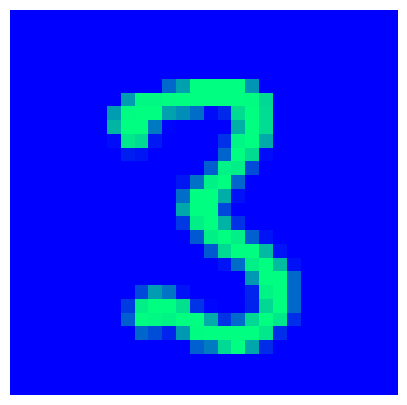

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(x_train[1499].reshape(28, 28).T, ax=ax, vmin=0, vmax=1, cmap='winter', xticklabels=False, yticklabels=False, cbar=False)

<AxesSubplot: >

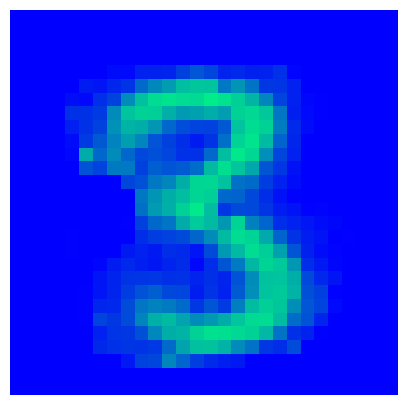

In [20]:
nn.forward_prop(x_train)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(nn.get_output()[1499].reshape(28, 28).T, ax=ax, vmin=0, vmax=1, cmap='winter', xticklabels=False, yticklabels=False, cbar=False)

In [21]:
def get_random_list(limit, num):
    random_list = list()
    iteration = 0
    while iteration < limit:
        r = random.randint(0, num - 1)
        if r not in random_list:
            random_list.append(r)
            iteration += 1
    return random_list


def get_index_digit(digit, data):
    index = list()
    for i, value in enumerate(data):
        if value == digit:
            index.append(i)
    return index


def get_error_digit(y, yhat, digits):
    ERRORS = 0
    for digit in digits:
        ERRORS += (0.5 * np.sum(((y[digit] - yhat[digit])**2)))                      
    return ERRORS / 784

In [22]:
random_sample = get_random_list(8, hidden_neurons)
print(random_sample)

[87, 161, 101, 164, 1, 175, 145, 75]


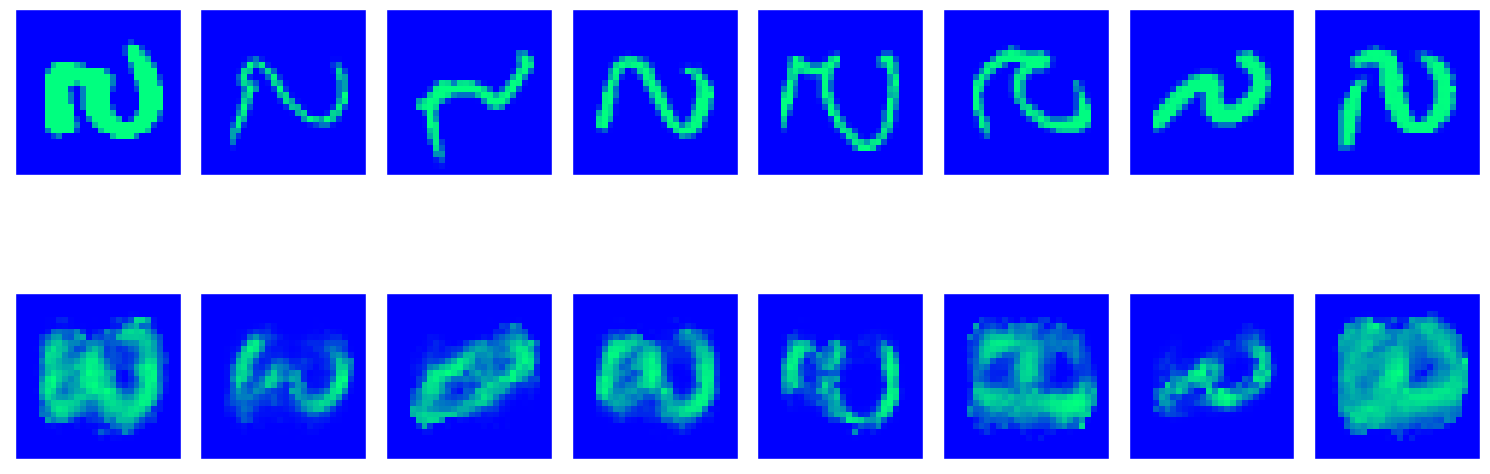

In [23]:
nn.forward_prop(x_test)
output_test = nn.get_output()
fig, ax = plt.subplots(2, 8, figsize=(15, 7))
plt.style.use('ggplot')
for i in range(len(random_sample)):
    ax[0, i].imshow(x_test[random_sample[i]].reshape(28, 28), cmap='winter')
    ax[1, i].imshow(output_test[random_sample[i]].reshape(28, 28), cmap='winter')
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
   
fig.tight_layout()
fig.savefig('../assets/sample_output.png')